# Analysis of TIC 105840719 / TOI 2123

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import stardate as sd
from tqdm import trange
import aviary as av

plotpar = {'axes.labelsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'legend.fontsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load TIC data file:

In [28]:
toi = pd.read_csv("data/TICv8_1_TIC_105840719.csv", skiprows=4)

Calculate absolute magnitude

In [8]:
def abs_mag(m, D):
    return m - 5*np.log10(D) + 5

MG = abs_mag(toi.GAIAmag, 1./toi.plx*1e3)

prot = 5.84106046
prot_err = 0.5* ((prot - 5.7168506) + (5.97237954 - prot))

Plot on a CMD and Period - Temperature diagram. Use the McQuillan sample to provide an indication of the kinematic ages of stars with similar Prots and Teffs (but note that these are likely to be overestimated for the youngest stars!).

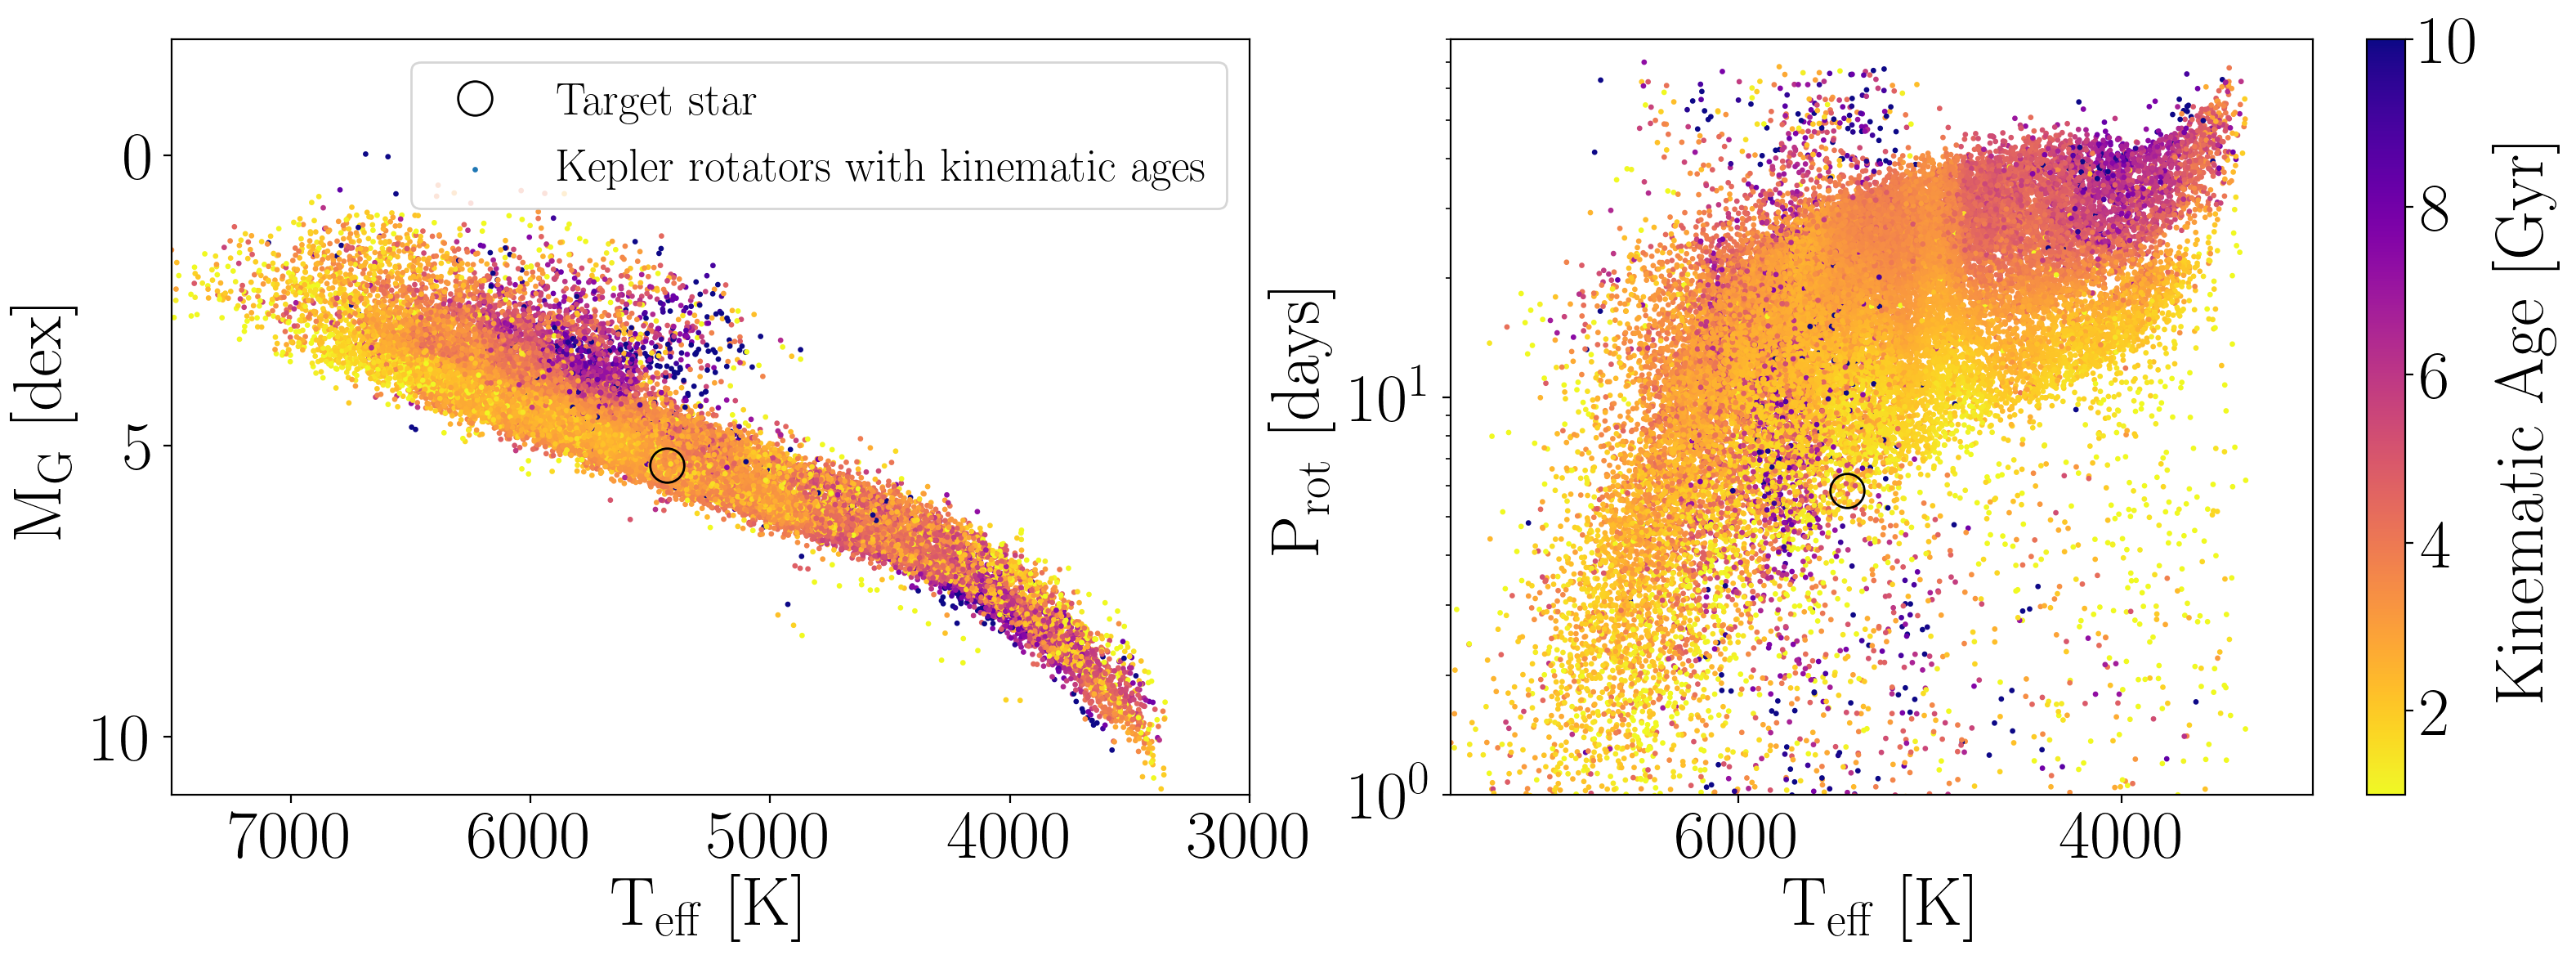

In [9]:
df = pd.read_csv("../data/bokeh_df.csv")

fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0,
            label="$\mathrm{Kepler~rotators~with~kinematic~ages}$")#, alpha=.5)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(toi.Teff, MG, "o", color="none", mec="k", ms=15, zorder=1, linewidth=10, label="$\mathrm{Target~star}$")
ax1.legend()

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(toi.Teff, prot, "o", color="none", mec="k", ms=15, zorder=1, linewidth=10)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

Calculating an age with stardate:

In [17]:
# Create a dictionary of observables
iso_params = {"J": (float(toi.Jmag.values), float(toi.e_Jmag.values)),
              "H": (float(toi.Hmag.values), float(toi.e_Hmag.values)),
              "K": (float(toi.Kmag.values), float(toi.e_Kmag.values)),
              "G": (float(toi.GAIAmag.values), float(toi.e_GAIAmag.values)),
              "BP": (float(toi.gaiabp.values), float(toi.e_gaiabp.values)),
              "RP": (float(toi.gaiarp.values), float(toi.e_gaiarp.values)),
              "parallax": (float(toi.plx.values), float(toi.e_plx.values))}
iso_params

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


{'J': (8.853, 0.028999999999999998),
 'H': (8.53, 0.021),
 'K': (8.44, 0.018000000000000002),
 'G': (10.0241, 0.0009519999999999999),
 'BP': (10.4267, 0.00279),
 'RP': (9.49125, 0.002199),
 'parallax': (11.5622, 0.030525200000000002)}

In [29]:
# Calculate good initial parameters:
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)
mass, age, feh = (toi.mass, np.log10(5e8), 0.07)
track = tracks.generate(mass, age, feh, return_dict=True) # "accurate=True" makes more accurate, but slower
EEP_init = track["eep"]

inits = [EEP_init, np.log10(5e8), 0.07, float(1./(toi.plx.values*1e-3)), 0]

In [30]:
# Set up the star object.
star = sd.Star(iso_params, prot=prot, prot_err=prot_err, Av=.01, Av_err=.1)

# Run the MCMC
star.fit(inits=inits, max_n=10000, burnin=100)

100%|██████████| 10000/10000 [02:42<00:00, 61.56it/s]

nsteps 10000 burnin 100


In [31]:
# # Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results(burnin=100)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

stellar age = 0.33 + 0.11 + 0.04


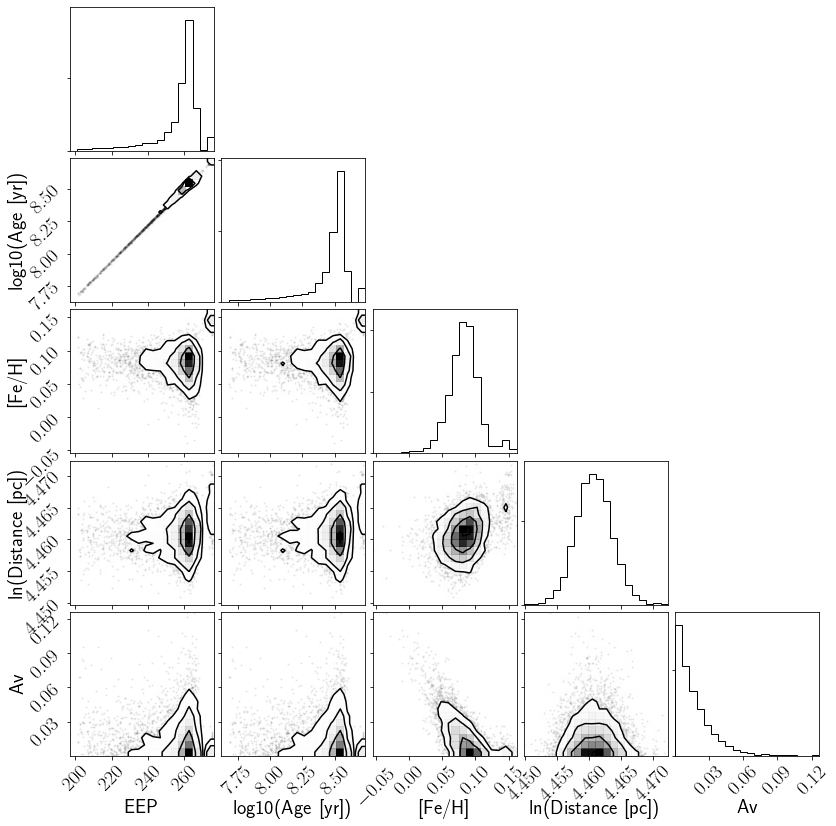

In [63]:
labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance [pc])", "Av"]
corner.corner(star.samples[::100], labels=labels);

Calculating a pure-gyro age:

In [43]:
import stardate2 as sd2
import emcee

ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 9

bprp = toi.gaiabp - toi.gaiarp

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[prot, prot_err, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 5000);

0.325556804203009


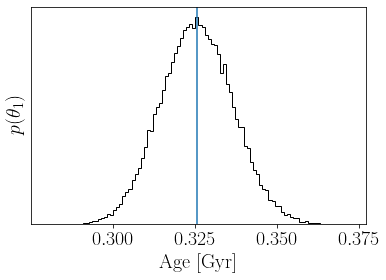

In [44]:
samples = sampler.get_chain(flat=True)
median_age = np.median((10**samples)*1e-9)
print(median_age)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);